<img src="https://www.unir.net/wp-content/uploads/2019/11/Unir_2021_logo.svg" width="240" height="240" align="right"/>

<center><h1>Trabajo de Fin de Master</header1></center>
<center><h1>Comparativa de Algoritmos de Aprendizaje Automático Aplicados a la Predicción de Cáncer de Colon a Partir de Datos Nutricionales</header1></center>

**Trabajo fin de estudio presentado por:**	Christian Suárez Heuvan<br>
**Tipo de trabajo:**	Comparativa de Soluciones<br>
**Director/a:**	Deivis Eduard Ramírez Martínez<br>
**Fecha:**	24/04/2025

# 1 Importación de Librerias Necesarias

In [68]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    classification_report, roc_auc_score, roc_curve,
    accuracy_score, precision_score, recall_score, f1_score
)

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from imblearn.over_sampling import SMOTE

# 2 Preparación del Conjunto de Datos

## 2.1 Carga y Fusión de los Dataset NHANES
Se importan y fusionan los 3 ficheros NHANES usando merged, mediante la clave común SEQN:
- Fichero DEMO_L.XPT: contiene información demográfica básica de los participantes.
- Fichero DR1TOT_L.XPT: resume la ingesta total de nutrientes y componentes dietéticos que han sido reportados por los participantes.
- Fichero MCQ_L.XPT: contine información médica 

In [69]:
# Carga de datasets NHANES
demo = pd.read_sas("DEMO_L.XPT", format='xport')
diet = pd.read_sas("DR1TOT_L.XPT", format='xport')
mcq = pd.read_sas("MCQ_L.XPT", format='xport')

# Comprobación dimensiones de cada dataset
print("DEMO:", demo.shape)
print("DIET:", diet.shape)
print("MCQ:", mcq.shape)

# Fusion de datasets DEMO y DIET
merged = demo.merge(diet, on="SEQN", how="inner")

# Fusion de resultado anterior con datasert MCQ
merged = merged.merge(mcq, on="SEQN", how="inner")

# Comprobación dimensiones finales
print("Dataset combinado:", merged.shape)

# Revisión de 5 primeras filas de los 3 datsets juntos
merged.head()

# Guardado datset como CSV
merged.to_csv("datasetsalud.csv", index=False)

print("Dataset guardado como datasetsalud.csv")

DEMO: (11933, 27)
DIET: (8860, 168)
MCQ: (11744, 35)
Dataset combinado: (8727, 228)
Dataset guardado como datasetsalud.csv


## 2.2 Limpieza del Conjunto de Datos
Limpieza y preparación del conjunto de datos para su utilización en por los algoritmos de predicción.

In [70]:
# Carga del dataset
df = pd.read_csv("datasetsalud.csv")

# Selección de las columnas relevantes para el estudio
columnas_interes = {
    'RIDAGEYR': 'Edad',
    'RIAGENDR': 'Genero',
    'DR1TCARB': 'Carbohidratos',
    'DR1TSUGR': 'Azucares',
    'DR1TALCO': 'Alcohol',
    'MCQ220': 'Cancer',
    'MCQ230A': 'Cancer_Colon1',
    'MCQ230B': 'Cancer_Colon2',
    'MCQ230C': 'Cancer_Colon3'
    
}
df = df[list(columnas_interes.keys())].rename(columns=columnas_interes)

# Comprobación selección de columnas necesarias
print("Dataset renombrado: ")
print(df.head(6))

# Normalización las columnas "Cáncer de Colon": 16 significa tener Cáncer de Colon. 
# Si se encuentra un 16 lo cambiamos a 1 ya que 1 significa tener Cáncer de Colon. Cualquier cosa diferente a 16 se pondrá un 2.
df['Cancer_Colon1'] = df['Cancer_Colon1'].apply(lambda x: 1 if x == 16 else 2)
df['Cancer_Colon2'] = df['Cancer_Colon2'].apply(lambda x: 1 if x == 16 else 2)
df['Cancer_Colon3'] = df['Cancer_Colon3'].apply(lambda x: 1 if x == 16 else 2)

# Fusión las 3 columnas Cáncer de Colon en una sola
df['Cancer_Colon'] = df[['Cancer_Colon1', 'Cancer_Colon2', 'Cancer_Colon3']].apply(
    lambda row: 1 if 1 in row.values else 2, axis=1
)

# Eliminación las 3 columnas
df.drop(['Cancer_Colon1', 'Cancer_Colon2', 'Cancer_Colon3'], axis=1, inplace=True)
print (df['Cancer_Colon'].value_counts().get(1, 0))

# Reemplazo de todos los NaN por 0
df.fillna(0, inplace=True)

# Reemplazo de valores muy pequeños por 0
for col in df.select_dtypes(include='number').columns:
    df[col] = df[col].apply(lambda x: 0 if isinstance(x, float) and x < 1e-10 else x)

# Verificación de valores extremos
valores_extremos = df[['Carbohidratos', 'Azucares', 'Alcohol']].describe()
print(valores_extremos)

# Guardado del dataset limpio
df.to_csv("datasetsalud_limpio.csv", index=False)
print("Dataset preprocesado: ", df.shape)

df.head(6)

Dataset renombrado: 
   Edad  Genero  Carbohidratos  Azucares       Alcohol  Cancer  Cancer_Colon1  \
0  43.0     1.0         169.66     43.71  3.420000e+01     2.0            NaN   
1  66.0     1.0         314.86    113.58  8.030000e+01     1.0           30.0   
2  44.0     2.0         281.67    114.66  5.397605e-79     2.0            NaN   
3   5.0     2.0         224.98    117.83  5.397605e-79     NaN            NaN   
4   2.0     1.0         194.30    112.99  5.397605e-79     NaN            NaN   
5  34.0     1.0         207.53     37.89  5.397605e-79     2.0            NaN   

   Cancer_Colon2  Cancer_Colon3  
0            NaN            NaN  
1            NaN            NaN  
2            NaN            NaN  
3            NaN            NaN  
4            NaN            NaN  
5            NaN            NaN  
41
       Carbohidratos     Azucares      Alcohol
count    8727.000000  8727.000000  8727.000000
mean      171.114415    73.964549     4.220339
std       137.683448    71.57

,Edad,Genero,Carbohidratos,Azucares,Alcohol,Cancer,Cancer_Colon
0,43.0,1.0,169.66,43.71,34.2,2.0,2
1,66.0,1.0,314.86,113.58,80.3,1.0,2
2,44.0,2.0,281.67,114.66,0.0,2.0,2
3,5.0,2.0,224.98,117.83,0.0,0.0,2
4,2.0,1.0,194.30,112.99,0.0,0.0,2
5,34.0,1.0,207.53,37.89,0.0,2.0,2


# 3 Evaluación con Modelos Predictivos

## 3.1 Carga y División del Conjunto de Datos
Carga del conjunto de datos previamente preparado, se establecen las variables de entrada del modelo y de salida. Por ultimo se divide el conjunto de datos en entrenamiento y prueba. 

In [71]:
#Carga del conjunto de datos
df = pd.read_csv("datasetsalud_limpio.csv")
df.columns = df.columns.str.strip()

# Filtra para seleccionar solo personas con algún tipo de cáncer
df_cancer = df[df["Cancer"] == 1]

# Dado que 1 es no tener cancer y 
#y = y.map({1: 0, 2: 1})  # 1 → No tiene, 2 → Sí tiene (reconvertido a 0/1)

# Definición del conjunto de variables predictorias (x) y variable objetivo (y)
X = df_cancer[["Carbohidratos", "Azucares", "Alcohol"]]
y = df_cancer["Cancer_Colon"]
print("Distribución original de clases:\n", y.value_counts())

# División del conjunto de datos
# Diviión de datos en entrenamiento y prueba (80%-20%) manteniendo la proporción de clases mediante muestreo estratificado.
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y)

Distribución original de clases:
 Cancer_Colon
2    869
1     41
Name: count, dtype: int64


## 3.2 Escalado y Balanceo
Dado que la clase positiva Cancer_Colon = 1 representaba un porcentaje muy pequeño del total, se produjo un desequilibrio lo cual afecta negativamente el rendimiento de los modelos de clasificación, obteniendo un 0 como valor para muchos estadísticos. Para solucionar este inconveniente de aplicaron dos estrategias:
- SMOTE para aumentar artificialmente los ejemplos de la clase minoritaria. Se usa en todos los modelos
- class_weight=’balanced’ para que los errores en la clase minoritaria, afirmativo en cáncer de colon, tenga mayor peso en el entrenamiento. Se usa en todos los modelos excepto en la Red Neuronal

In [72]:
# Se estandarizan los datos de prueba, transformándolos para que tengan media 0 y desviación estándar 1
scaler = StandardScaler()
X_test_scaled = scaler.fit_transform(X_test)

#Generación de muestras sintéticas para balancear las clases del conjunto de entrenamiento y luego estandariza los datos resultantes.
smote = SMOTE(random_state=42)
# Modelo sin escalar
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)
# Modelo con StandarScaler
X_train_resampled_scaled = scaler.fit_transform(X_train_resampled)

## 3.3 Definición de Modelos
Definiciaón de los 4 modelos que se compararán para la predicción de cáncer:
- Árbol de Decisión
- Random Forest
- Regresión Logística
- Red Neuronal

In [73]:
# Definición de un diccionario con cuatro modelos de clasificación supervisada.
# El desbalance de clases de los 3 primero modelos se trata mediante el parámetro class_weight='balanced'
modelos = {
    "Árbol de Decisión": DecisionTreeClassifier(random_state=42, class_weight='balanced'),
    "Random Forest": RandomForestClassifier(random_state=42, class_weight='balanced'),
    "Regresión Logística": LogisticRegression(max_iter=1000, random_state=42, class_weight='balanced'),
    # MLPClassifier no admite el parámetro class_weight. El desbalance se compensa previamente aplicando SMOTE sobre los datos de entrenamiento.
    "Red Neuronal": MLPClassifier(hidden_layer_sizes=(100,), max_iter=1000, random_state=42)
}

## 3.4 Entrenamiento y Evaluación de Modelos
Entrenamiento con cada uno de los cuatro modelos escogidos. Para el Árbol de Decisión y Random Forest se utilizaron los datos balanceados sin estandarizar, ya que estos modelos no requieren normalización. En cambio, para la Regresión Logística y la Red Neuronal se utilizaron los datos balanceados y estandarizados, dado que estos modelos son sensibles a la escala de los datos.<br>
Para cada modelo se calcularon las siguientes métricas: Accuracy o exactitud, Precisión, Recall que indica la sensibilidad o tasa de verdaderos positivos, F1-Score que indica la media armónica entre precisión y recall y el AUC-ROC o área bajo la curva ROC


Evaluación del modelo: Árbol de Decisión
Tiempo de entrenamiento: 0.0227 segundos
              precision    recall  f1-score   support

           1       0.02      0.12      0.04         8
           2       0.95      0.75      0.84       174

    accuracy                           0.73       182
   macro avg       0.49      0.44      0.44       182
weighted avg       0.91      0.73      0.80       182

AUC ROC: 0.4256


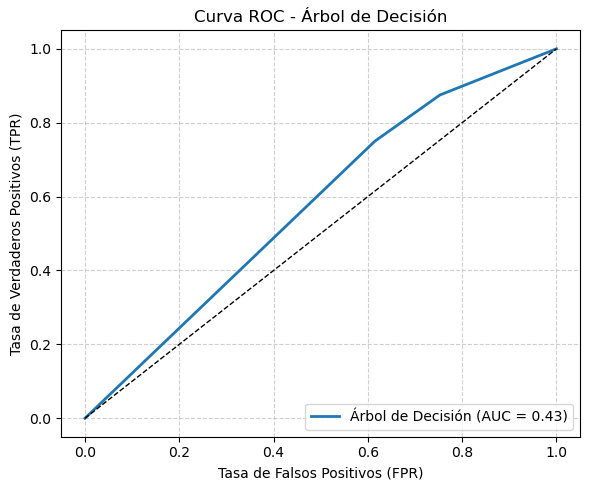


Evaluación del modelo: Random Forest
Tiempo de entrenamiento: 0.4303 segundos
              precision    recall  f1-score   support

           1       0.03      0.12      0.04         8
           2       0.95      0.79      0.87       174

    accuracy                           0.76       182
   macro avg       0.49      0.46      0.45       182
weighted avg       0.91      0.76      0.83       182

AUC ROC: 0.3531


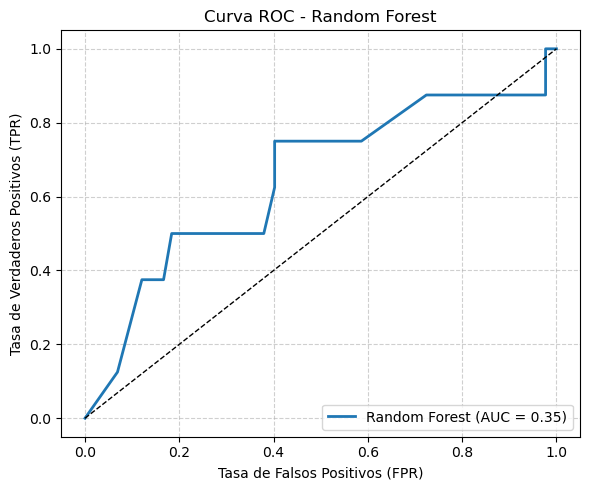


Evaluación del modelo: Regresión Logística
Tiempo de entrenamiento: 0.0066 segundos
              precision    recall  f1-score   support

           1       0.03      0.50      0.06         8
           2       0.91      0.24      0.38       174

    accuracy                           0.25       182
   macro avg       0.47      0.37      0.22       182
weighted avg       0.87      0.25      0.37       182

AUC ROC: 0.3305


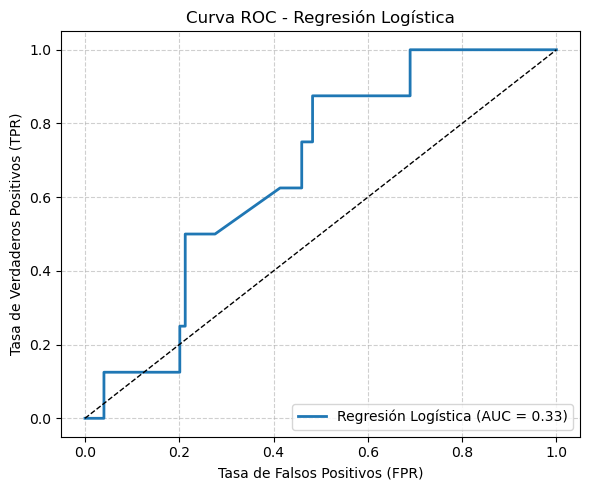


Evaluación del modelo: Red Neuronal
Tiempo de entrenamiento: 2.7794 segundos
              precision    recall  f1-score   support

           1       0.04      0.12      0.06         8
           2       0.96      0.86      0.91       174

    accuracy                           0.83       182
   macro avg       0.50      0.49      0.48       182
weighted avg       0.92      0.83      0.87       182

AUC ROC: 0.5564


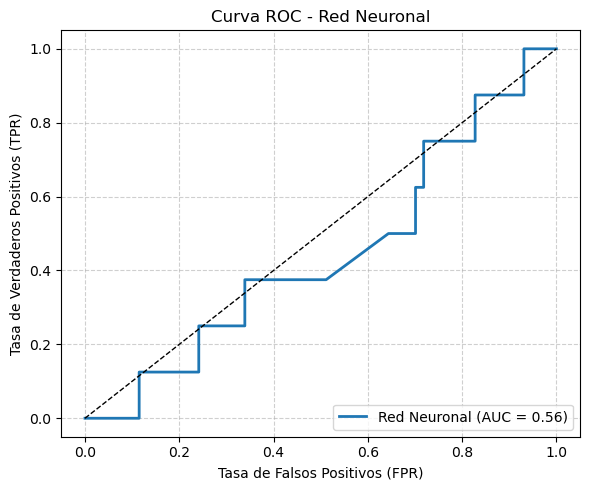

In [74]:
# Inicializamos lista vacia
resultados = []

for nombre, modelo in modelos.items():
    print(f"\nEvaluación del modelo: {nombre}")
    start_time = time.time()  # Inicia el cronómetro para medir tiempos de entrenamiento

    # Uso de datos escalados (datos con la misma escala: media=0 desviación standar=1) solo para la Regresión Logística y la Red Neuronal
    # y datos sin escalar para los demás ya que no todos los algoritmos requieren normalización
    if nombre in ["Regresión Logística", "Red Neuronal"]:
        modelo.fit(X_train_resampled_scaled, y_train_resampled)
        y_pred = modelo.predict(X_test_scaled)
        y_proba = modelo.predict_proba(X_test_scaled)[:, 1]
    else:
        modelo.fit(X_train_resampled, y_train_resampled)
        y_pred = modelo.predict(X_test)
        y_proba = modelo.predict_proba(X_test)[:, 1]

    end_time = time.time()  # Termina el cronómetro de tiempo de entrenamiento
    training_time = end_time - start_time  # Duración en segundos
    print(f"Tiempo de entrenamiento: {training_time:.4f} segundos")

    # Gerenación del informe de clasificación con métricas
    print(classification_report(y_test, y_pred, zero_division=0))

    # Cálculo del valor AUC-ROC
    auc = roc_auc_score(y_test, y_proba)
    print(f"AUC ROC: {round(auc, 4)}")

    # Se muestran todos os resultados
    resultados.append({
        "Modelo": nombre,
        "Accuracy": accuracy_score(y_test, y_pred),
        "Precision": precision_score(y_test, y_pred, pos_label=1, zero_division=0),
        "Recall": recall_score(y_test, y_pred, pos_label=1, zero_division=0),
        "F1 Score": f1_score(y_test, y_pred, pos_label=1, zero_division=0),
        "AUC ROC": auc,
        "Tiempo Entrenamiento": training_time
    })
    
 # Generación de la Curva ROC por modelo
    fpr, tpr, _ = roc_curve(y_test, y_proba, pos_label=1)
    plt.figure(figsize=(6, 5))
    plt.plot(fpr, tpr, label=f"{nombre} (AUC = {auc:.2f})", linewidth=2)
    plt.plot([0, 1], [0, 1], 'k--', linewidth=1)
    plt.title(f"Curva ROC - {nombre}", fontsize=12)
    plt.xlabel("Tasa de Falsos Positivos (FPR)")
    plt.ylabel("Tasa de Verdaderos Positivos (TPR)")
    plt.legend(loc="lower right")
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.tight_layout()
    plt.savefig(f"curva_ROC_{nombre.replace(' ', '_').lower()}.png", dpi=300, bbox_inches='tight')
    plt.show()

## 3.5 Comparación de Curvas ROC entre Modelos
Generación y comparación de las curvas ROC de cada modelo, utilizando probabilidades de predicción (escaladas o no según corresponda) y calculando su AUC.
Finalmente, se produce la generación y guardado de la gráfica con el título "curvas_ROC_comparadas.png".

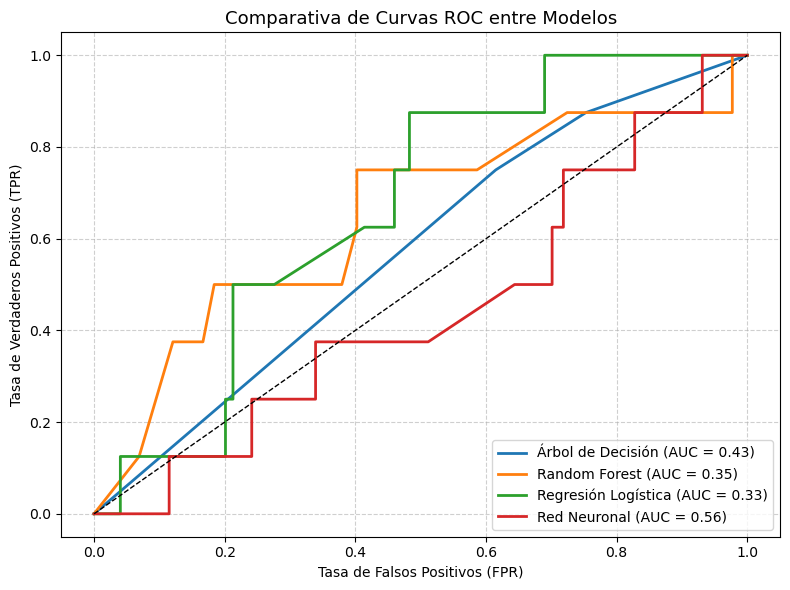

In [75]:
plt.figure(figsize=(8, 6))

# Se recorre cada modelo
for resultado, nombre in zip(resultados, modelos.keys()):
    modelo_entrenado = modelos[nombre]

    # Calculo de probabilidades de prediccón de la clase positiva (y_proba) usando datos escalados solo si el modelo es sensible a la escala,
    # en caso contrario usa los datos originales
    if nombre in ["Regresión Logística", "Red Neuronal"]:
        y_proba = modelo_entrenado.predict_proba(X_test_scaled)[:, 1]
    else:
        y_proba = modelo_entrenado.predict_proba(X_test)[:, 1]

    # Cálculo de false positive y true positive para obtener curva ROC
    fpr, tpr, _ = roc_curve(y_test, y_proba, pos_label=1)
    auc = resultado["AUC ROC"]
    plt.plot(fpr, tpr, label=f"{nombre} (AUC = {auc:.2f})", linewidth=2)

plt.plot([0, 1], [0, 1], 'k--', linewidth=1) # Trazo de la diagonal
plt.title("Comparativa de Curvas ROC entre Modelos", fontsize=13) # 
plt.xlabel("Tasa de Falsos Positivos (FPR)")
plt.ylabel("Tasa de Verdaderos Positivos (TPR)")
plt.legend(loc="lower right")
plt.grid(True, linestyle='--', alpha=0.6) # Grafico de cuadrícula con puntos
plt.tight_layout() # Ajuste de márgenes de la gráfica
plt.savefig("curvas_ROC_comparadas.png", dpi=300, bbox_inches='tight')
plt.show()

## 3.6 Tabla Comparativa de Resultado
Tabla de resúmen comparativo de resultados entre los diferentes modelos ordenados por AUC ROC.

In [76]:
df_resultados = pd.DataFrame(resultados)
df_resultados = df_resultados.round(3).sort_values(by="AUC ROC", ascending=False)

print("\nResumen comparativo de modelos (ordenado por AUC ROC):")
print(df_resultados)


Resumen comparativo de modelos (ordenado por AUC ROC):
                Modelo  Accuracy  Precision  Recall  F1 Score  AUC ROC  \
3         Red Neuronal     0.830      0.040   0.125     0.061    0.556   
0    Árbol de Decisión     0.725      0.023   0.125     0.038    0.426   
1        Random Forest     0.764      0.027   0.125     0.044    0.353   
2  Regresión Logística     0.253      0.029   0.500     0.056    0.330   

   Tiempo Entrenamiento  
3                 2.779  
0                 0.023  
1                 0.430  
2                 0.007  


# 4 Comparativa de los Modelos de Clasificación en Función de las Metricas Analizadas

## 4.1 Comparativa de Modelos Clasificación en función de métrica F1-score

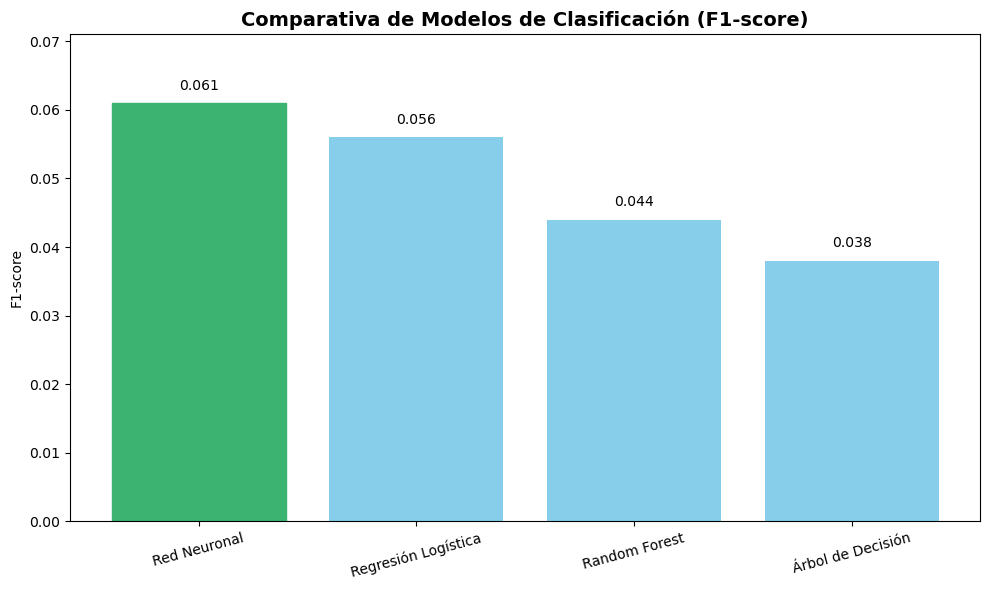

In [77]:
modelos = [
    "Árbol de Decisión",
    "Random Forest",
    "Regresión Logística",
    "Red Neuronal"
]
# Se añaden valores manualmente porque en cada ejecución cambian. Y estos gráficos se usaron para la explicación de la memoría.
# es por ello, que a pesar de que pueden tomar lo valores de forma automatica, se ha decidido ponerlos manual.
f1_scores = [0.038, 0.044, 0.056, 0.061]  #valores a sustituir

# Ordenación de modelos de mayor a menor F1
orden = sorted(zip(f1_scores, modelos), reverse=True)
f1_scores_ordenados, modelos_ordenados = zip(*orden)

# Generación del gráfico
fig, ax = plt.subplots(figsize=(10, 6))
bars = ax.bar(modelos_ordenados, f1_scores_ordenados, color='skyblue')

# Resaltado del mejor de los 4 modelos
bars[0].set_color('mediumseagreen')

# Etiquetado de valores
for bar in bars:
    yval = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2, yval + 0.0015, f"{yval:.3f}",
            ha='center', va='bottom', fontsize=10)

# Mejora de la gráfica
ax.set_title("Comparativa de Modelos de Clasificación (F1-score)", fontsize=14, weight='bold')
ax.set_ylabel("F1-score")
ax.set_ylim(0, max(f1_scores_ordenados) + 0.01)
plt.xticks(rotation=15)
plt.tight_layout()

# Mostrar gráfica
plt.show()

## 4.2 Comparativa de Modelos Clasificación en función de métrica Acurracy

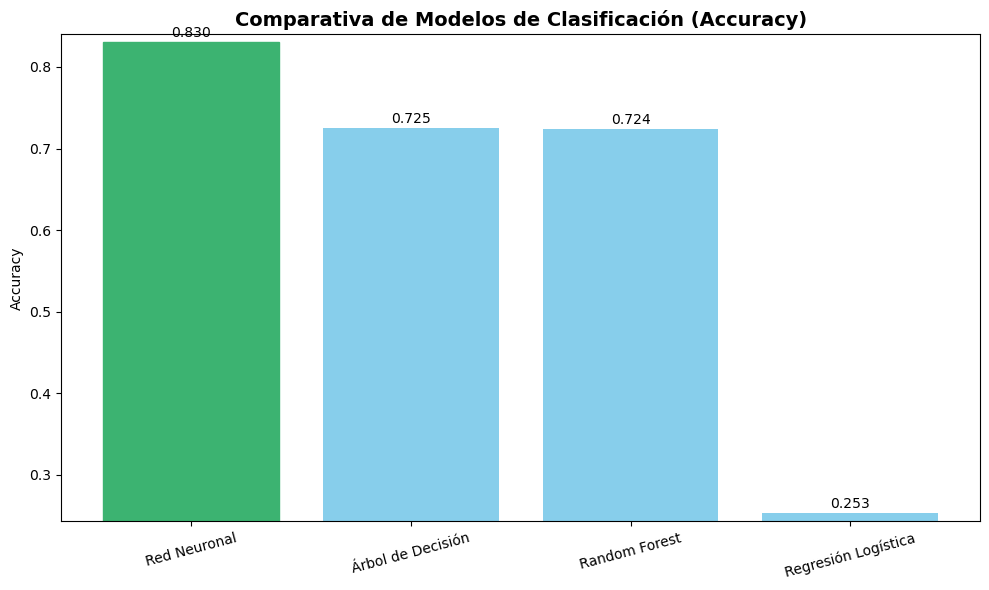

In [78]:
modelos = [
    "Árbol de Decisión",
    "Random Forest",
    "Regresión Logística",
    "Red Neuronal"
]
# Se añaden valores manualmente porque en cada ejecución cambian. Y estos gráficos se usaron para la explicación de la memoría.
# es por ello, que a pesar de que pueden tomar lo valores de forma automatica, se ha decidido ponerlos manual.
accuracy_scores = [0.725, 0.724, 0.253, 0.830]  # valores manuales

# Ordenación de modelos de mayor a menor Accuracy
orden = sorted(zip(accuracy_scores, modelos), reverse=True)
accuracy_ordenados, modelos_ordenados = zip(*orden)

# Generación del gráfico
fig, ax = plt.subplots(figsize=(10, 6))
bars = ax.bar(modelos_ordenados, accuracy_ordenados, color='skyblue')

# Resaltado del mejor de los 4 modelos
bars[0].set_color('mediumseagreen')

# Etiquetado
for bar in bars:
    yval = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2, yval + 0.003, f"{yval:.3f}",
            ha='center', va='bottom', fontsize=10)

# Mejora de la gráfica
ax.set_title("Comparativa de Modelos de Clasificación (Accuracy)", fontsize=14, weight='bold')
ax.set_ylabel("Accuracy")
ax.set_ylim(min(accuracy_ordenados) - 0.01, max(accuracy_ordenados) + 0.01)  
plt.xticks(rotation=15)
plt.tight_layout()

# Mostrar gráfica
plt.show()


## 4.2 Comparativa de Modelos Clasificación en función de métrica Presición

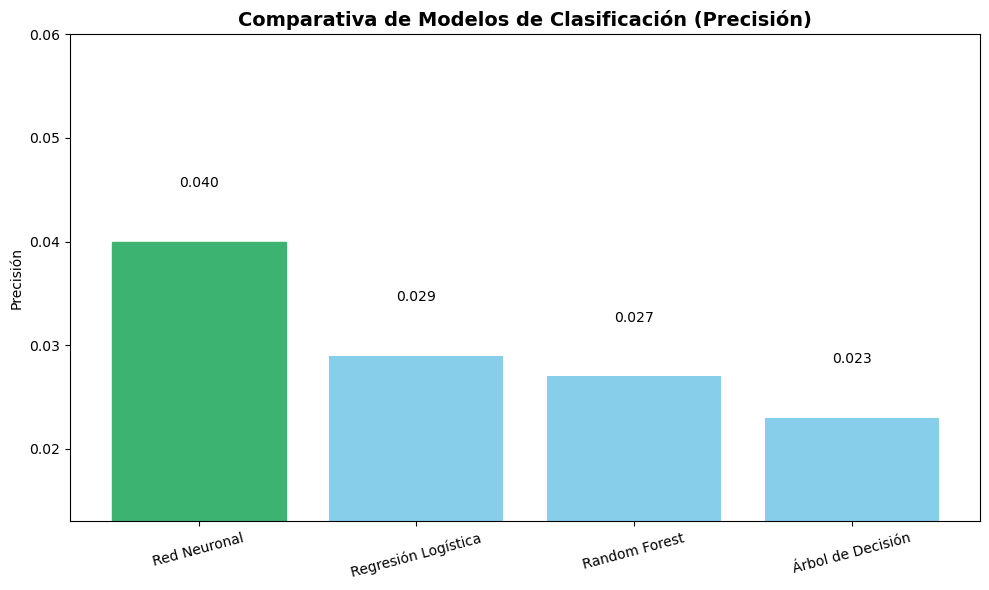

In [79]:
modelos = [
    "Árbol de Decisión",
    "Random Forest",
    "Regresión Logística",
    "Red Neuronal"
]
# Se añaden valores manualmente porque en cada ejecución cambian. Y estos gráficos se usaron para la explicación de la memoría.
# es por ello, que a pesar de que pueden tomar lo valores de forma automatica, se ha decidido ponerlos manual.
precision_scores = [0.023, 0.027, 0.029, 0.040]  # valores manuales

# Ordenación de modelos de mayor a menor precisión
orden = sorted(zip(precision_scores, modelos), reverse=True)
precision_ordenados, modelos_ordenados = zip(*orden)

# Generación del gráfico
fig, ax = plt.subplots(figsize=(10, 6))
bars = ax.bar(modelos_ordenados, precision_ordenados, color='skyblue')

# Resaltado del mejor de los 4 modelos
bars[0].set_color('mediumseagreen')

# Etiquetado de valores
for bar in bars:
    yval = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2, yval + 0.005, f"{yval:.3f}",
            ha='center', va='bottom', fontsize=10)

# Mejora de la gráfica
ax.set_title("Comparativa de Modelos de Clasificación (Precisión)", fontsize=14, weight='bold')
ax.set_ylabel("Precisión")
ax.set_ylim(min(precision_ordenados) - 0.01, max(precision_ordenados) + 0.02)
plt.xticks(rotation=15)
plt.tight_layout()

# Mostrar gráfica
plt.show()


## 4.2 Comparativa de Modelos Clasificación en función de métrica Recall

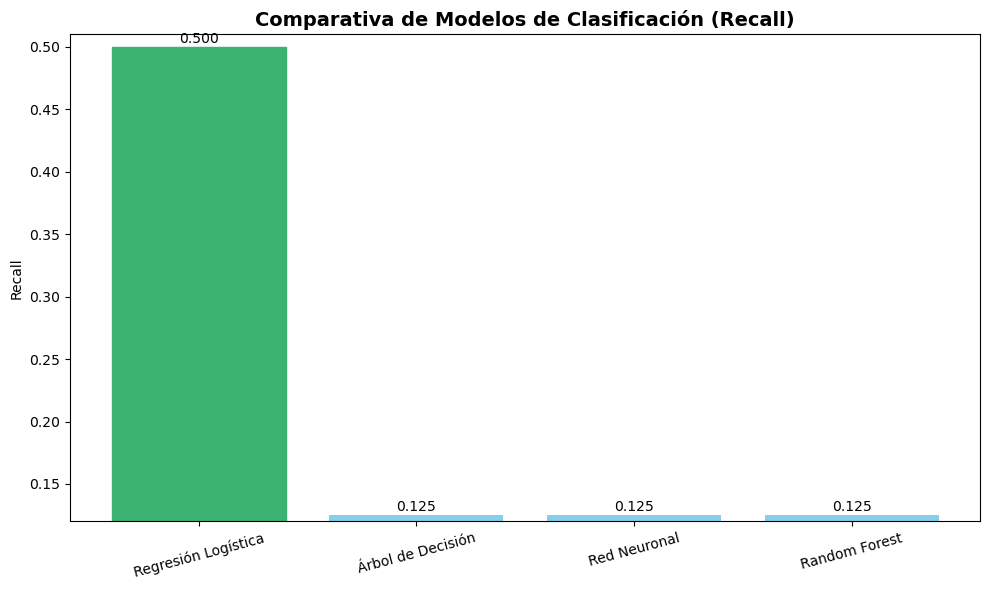

In [80]:
modelos = [
    "Árbol de Decisión",
    "Random Forest",
    "Regresión Logística",
    "Red Neuronal"
]
# Se añaden valores manualmente porque en cada ejecución cambian. Y estos gráficos se usaron para la explicación de la memoría.
# es por ello, que a pesar de que pueden tomar lo valores de forma automatica, se ha decidido ponerlos manual.
recall_scores = [0.125, 0.125, 0.500, 0.125]  # Valores manuales

# Ordenación de de mayor a menor
orden = sorted(zip(recall_scores, modelos), reverse=True)
recall_ordenados, modelos_ordenados = zip(*orden)

# Generación del gráfico
fig, ax = plt.subplots(figsize=(10, 6))
bars = ax.bar(modelos_ordenados, recall_ordenados, color='skyblue')

# Resaltado del mejor de los 4 modelos
bars[0].set_color('mediumseagreen')

# Etiquetado de valores
for bar in bars:
    yval = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2, yval + 0.001, f"{yval:.3f}",
            ha='center', va='bottom', fontsize=10)

# Mejora de la gráfica
ax.set_title("Comparativa de Modelos de Clasificación (Recall)", fontsize=14, weight='bold')
ax.set_ylabel("Recall")
ax.set_ylim(min(recall_ordenados) - 0.005, max(recall_ordenados) + 0.01)
plt.xticks(rotation=15)
plt.tight_layout()

# Mostrar gráfica
plt.show()

## 4.2 Comparativa de Modelos Clasificación en función de métrica AUC-ROC

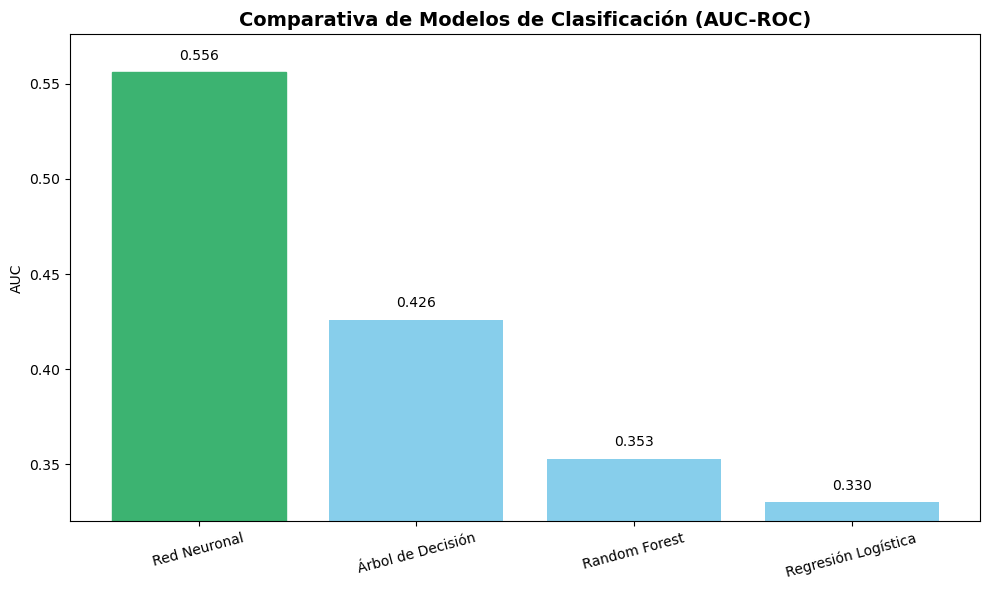

In [81]:
modelos = [
    "Árbol de Decisión",
    "Random Forest",
    "Regresión Logística",
    "Red Neuronal"
]
# Se añaden valores manualmente porque en cada ejecución cambian. Y estos gráficos se usaron para la explicación de la memoría.
# es por ello, que a pesar de que pueden tomar lo valores de forma automatica, se ha decidido ponerlos manual.
auc_scores = [0.426, 0.353, 0.330, 0.556]  # valores manuales

# Ordenación de modelos de mayor a menor AUC
orden = sorted(zip(auc_scores, modelos), reverse=True)
auc_ordenados, modelos_ordenados = zip(*orden)

# Generación del gráfico
fig, ax = plt.subplots(figsize=(10, 6))
bars = ax.bar(modelos_ordenados, auc_ordenados, color='skyblue')

# Resaltado del mejor de los 4 modelos
bars[0].set_color('mediumseagreen')

# Etiquetado de valores
for bar in bars:
    yval = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2, yval + 0.005, f"{yval:.3f}",
            ha='center', va='bottom', fontsize=10)

# Mejora de la gráfica
ax.set_title("Comparativa de Modelos de Clasificación (AUC-ROC)", fontsize=14, weight='bold')
ax.set_ylabel("AUC")
ax.set_ylim(min(auc_ordenados) - 0.01, max(auc_ordenados) + 0.02)
plt.xticks(rotation=15)
plt.tight_layout()

# Mostrar gráfica
plt.show()

# 5 Ejemplo de Predicción con el Mejor Modelo
Ejemplo de demostracion de como el mejor de los modelos, en este caso: Red Neuronal, predice un caso hipotético.

In [84]:
# Aplicar SMOTE
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

# Estandarizar los datos
scaler = StandardScaler()
X_train_resampled_scaled = scaler.fit_transform(X_train_resampled)

# Predicción para un caso hipotético
nuevo_paciente = pd.DataFrame({
    "Carbohidratos": [200],
    "Azucares": [90],
    "Alcohol": [10]
})

# Escalar si el modelo lo necesita (Solo si es regresión Logística o Red Neuronal). 
# Transformar los datos del nuevo paciente a la misma escala que los datos usados para entrenar el modelo (media = 0  y desviación estandar = 1).
nuevo_paciente_scaled = scaler.transform(nuevo_paciente)

# Crear y entrenar nuevamente el modelo final
modelo_final = MLPClassifier(hidden_layer_sizes=(100,), max_iter=1000, random_state=42)
modelo_final.fit(X_train_resampled_scaled, y_train_resampled)

# Predicción
prediccion = modelo_final.predict(nuevo_paciente_scaled)
probabilidad = modelo_final.predict_proba(nuevo_paciente_scaled)[0][1]

print(f"¿Predicción de cáncer de colon?: {'Sí' if prediccion[0] == 2 else 'No'} (Probabilidad: {probabilidad:.2f})")

¿Predicción de cáncer de colon?: Sí (Probabilidad: 0.83)
